# Model baselines

This notebook is devoted to find simple models to state that data is somehow feasible to use for regression. Let's read the data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import pydotplus
from IPython.display import Image

from widedeep.utils import *
from widedeep.data.display import *
from widedeep.data.data_ops import *

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

def mean_error(pred, truth):
    return np.mean(np.abs(pred - truth))
    
def rmse(pred, truth):
    return np.sqrt(np.mean(np.square(pred - truth)))

def median_error(pred, truth):
    return np.median(np.abs(pred - Y_test))

def print_errors(model, train_X, test_X, train_Y, test_Y):
    train_error = mean_error(model.predict(train_X), train_Y)
    train_rmse = rmse(model.predict(train_X), train_Y)
    print('[Train] Mean error on is %f and rmse is %f' % (train_error, train_rmse))
    test_error = mean_error(model.predict(test_X), test_Y)
    test_rmse = rmse(model.predict(test_X), test_Y)
    print('[Test] Mean error on is %f and rmse is %f' % (test_error, test_rmse))

def print_predictions(model, train_X, test_X):
    print('[Train] Mean prediction for model %f' % model.predict(train_X).mean())
    print('[Train] Std prediction for model %f' % model.predict(train_X).std())
    print('[Test] Mean prediction for model %f' % model.predict(test_X).mean())
    print('[Test] Std prediction for model %f' % model.predict(test_X).std())
    
data = pd.read_csv(AIRBNB_FINAL)

## Modeling prices and availability

Let's use simple approaches to predict lodging prices. We decide to use a subset of the data including 8 cities. The results we get here are a lower bound as we expect performance to improve using more data.

In [2]:
cities = data['area'].unique().tolist()
data_subset = data[data['area'].isin(cities[:8])]
print('Using %d instances and %d columns' % (data_subset.shape[0], data_subset.shape[1]))

Using 96532 instances and 72 columns


### Numerical version the data

Now we will generate an additional version of the data so it can be handled as a fully dense numerical data set. To do so, we will convert each categorical column into dummy binary features.

In [3]:
excl = ['listing_url', 'last_scraped', 'id', 'scrape_id', 'picture_url']
# Convert into boolean
num_data = convert_to_dummy(data_subset, excluded_columns=excl)
num_data = convert_boolean(num_data, func=float)

2017-02-28 21:24:57,849 - data - INFO - Converting area into dummy column ...


/home/walle/workspace/pfm/code/widedeep/data/data_ops.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[dummy_name] = data[name].apply(lambda x: is_equal(x, val))


2017-02-28 21:24:58,382 - data - INFO - Converting bed_type into dummy column ...
2017-02-28 21:24:58,495 - data - INFO - Converting cancellation_policy into dummy column ...
2017-02-28 21:24:58,587 - data - INFO - Converting country into dummy column ...
2017-02-28 21:24:58,703 - data - INFO - Converting property_type into dummy column ...
2017-02-28 21:24:58,934 - data - INFO - Converting review_scores_accuracy into dummy column ...
2017-02-28 21:24:59,024 - data - INFO - Converting review_scores_checkin into dummy column ...
2017-02-28 21:24:59,116 - data - INFO - Converting review_scores_cleanliness into dummy column ...
2017-02-28 21:24:59,207 - data - INFO - Converting review_scores_communication into dummy column ...
2017-02-28 21:24:59,297 - data - INFO - Converting review_scores_location into dummy column ...
2017-02-28 21:24:59,389 - data - INFO - Converting review_scores_rating into dummy column ...
2017-02-28 21:24:59,481 - data - INFO - Converting review_scores_value into 

## Validation set and scaling

Let's separate data between training and validation. We are also scaling data so it lies around 0 (mean 0) and the standard deviation of each column is 1.

In [5]:
# X and Y as inputs of models
excluded_cols = ['id', 'picture_url', 'scrape_id', 'listing_url', 'last_scraped', 'availability_365']
features = [f for f in num_data.columns.values if f not in excluded_cols]
X, Y = num_data[features], num_data['availability_365']

# Split data into training and test
train_inds, _, test_inds = split_data(len(X), 0.80, 0.10)
X_train, Y_train = X.iloc[train_inds], Y.iloc[train_inds]
X_test, Y_test = X.iloc[test_inds], Y.iloc[test_inds]

# Finally, let's generate a scaled version of the data that has mean 0 and std of 1
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_s, X_test_s = scaler.transform(X_train), scaler.transform(X_test)

Let's also visualize characteristics of the input target:

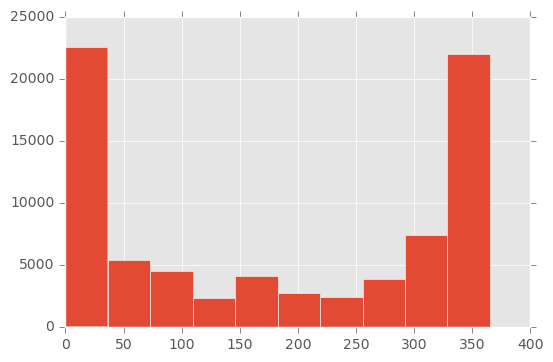

In [6]:
num_data.iloc[train_inds]['availability_365'].hist()

In [7]:
print('Mean price for groundtruth %f' % num_data['availability_365'].mean())
print('Std of price for groundtruth %f' % num_data['availability_365'].std())

Mean price for groundtruth 181.808696
Std of price for groundtruth 146.236636


## Linear regression

We can try to approximate the price using the simplest model: a Linear Regression. This model predicts the output by performing a dot product between the input features (numeric) and the learnt weights, which minimize the distance between the predicted value and the true value.

In [8]:
# Try linear model and see coefficients
lr = LinearRegression(fit_intercept=True, normalize=False, n_jobs=2)
lr = lr.fit(X_train_s, Y_train)
coeffs = zip(features, lr.coef_)
for (n, c) in coeffs:
    print('Coefficient for %s is %f' % (n, c))

Coefficient for accommodates is 3.443055
Coefficient for bathrooms is -6.585780
Coefficient for bedrooms is -13.853510
Coefficient for beds is 6.588675
Coefficient for cleaning_fee is 10.758206
Coefficient for final_price is 15.165332
Coefficient for guests_included is -2.326442
Coefficient for host_has_profile_pic is -0.324761
Coefficient for host_identity_verified is -1.351136
Coefficient for host_is_superhost is 4.984918
Coefficient for host_verifications is -1.219834
Coefficient for instant_bookable is -3.967701
Coefficient for minimum_nights is 1.006575
Coefficient for recent_review is 13.655868
Coefficient for reviews_per_month is 4.715876
Coefficient for security_deposit is 0.213840
Coefficient for extra_people is 12.548218
Coefficient for suitable for events is 2.630769
Coefficient for dog(s) is -2.998779
Coefficient for safety card is -1.380828
Coefficient for pets allowed is 2.909247
Coefficient for breakfast is 1.139534
Coefficient for doorman is -0.824616
Coefficient for pe

Histogram of test predictions for linear regression


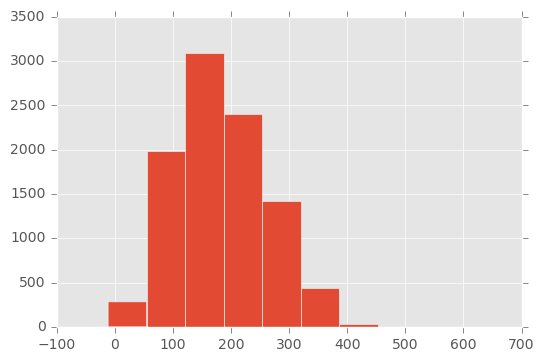

In [9]:
print('Histogram of test predictions for linear regression')
plt.hist(lr.predict(X_test_s))
plt.show()

In [10]:
print_errors(lr, X_train_s, X_test_s, Y_train, Y_test)

[Train] Mean error on is 107.242034 and rmse is 124.405291
[Test] Mean error on is 107.221703 and rmse is 124.375439


In [11]:
print_predictions(lr, X_train_s, X_test_s)

[Train] Mean prediction for model 182.002009
[Train] Std prediction for model 76.728755
[Test] Mean prediction for model 182.783004
[Test] Std prediction for model 77.645462


## Non-linear models

We know that a problem with such complexity will rarely be linear. Let's see if the results improve once we use a non-linear model such as a Multi-layer Perceptron (MLP).

In [14]:
def log_step(model, data_inp, data_gt, step, prefix):
    predicted = model.predict(data_inp)
    err = mean_error(predicted, data_gt)
    rmse_err = rmse(predicted, data_gt)
    print('[Iteration %d, Loss %f] %s error is %f and rmse is %f' 
          % (step, mlp.loss_, prefix, err, rmse_err))
    
# Train iteratively
num_steps = 100
mlp = MLPRegressor(activation='tanh', 
                   # solver='lbfgs',
                   solver='adam',
                   alpha=1e-5,
                   learning_rate_init=0.10,
                   hidden_layer_sizes=(25, 25, 25),
                   warm_start=False, 
                   max_iter=1)

# Iterative fitting of the MLP
for s in range(num_steps):
    mlp = mlp.fit(X_train_s, Y_train)
    
    # Log each 10 iterations
    if s % 10 == 0:
        log_step(mlp, X_train_s, Y_train, s, 'training')
        log_step(mlp, X_test_s, Y_test, s, 'testing')

# Extract stats from the predicted training instances
predicted = mlp.predict(X_train_s)
print('Mean of predicted data is %f' % predicted.mean())
print('Std of predicted data is %f' % predicted.std())

[Iteration 0, Loss 10621.301311] training error is 116.193606 and rmse is 130.596702
[Iteration 0, Loss 10621.301311] testing error is 116.654382 and rmse is 131.032348
[Iteration 10, Loss 11786.403471] training error is 136.348200 and rmse is 146.092303
[Iteration 10, Loss 11786.403471] testing error is 137.269913 and rmse is 146.791890
[Iteration 20, Loss 10543.700014] training error is 115.766009 and rmse is 131.156719
[Iteration 20, Loss 10543.700014] testing error is 115.779231 and rmse is 131.210759
[Iteration 30, Loss 10761.867778] training error is 114.379890 and rmse is 130.395353
[Iteration 30, Loss 10761.867778] testing error is 114.858488 and rmse is 130.860252
[Iteration 40, Loss 11294.618084] training error is 119.178070 and rmse is 132.930115
[Iteration 40, Loss 11294.618084] testing error is 119.582185 and rmse is 133.216279
[Iteration 50, Loss 11726.355007] training error is 136.345368 and rmse is 146.094673
[Iteration 50, Loss 11726.355007] testing error is 137.256732

In [15]:
print_errors(mlp, X_train_s, X_test_s, Y_train, Y_test)

[Train] Mean error on is 114.799222 and rmse is 132.112745
[Test] Mean error on is 115.093992 and rmse is 132.453746


In [16]:
print_predictions(mlp, X_train_s, X_test_s)

[Train] Mean prediction for model 180.711124
[Train] Std prediction for model 69.005276
[Test] Mean prediction for model 180.790804
[Test] Std prediction for model 69.279659


Histogram of training data


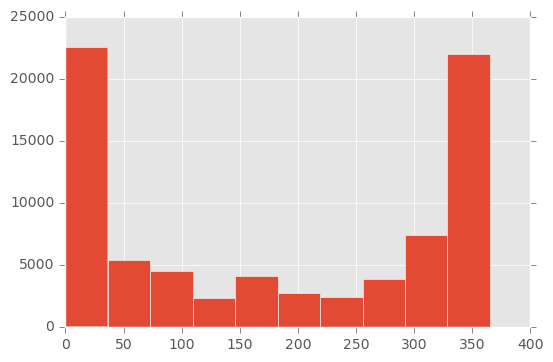

In [17]:
print('Histogram of training data')
plt.hist(Y_train)
plt.show()

Histogram of predicted data


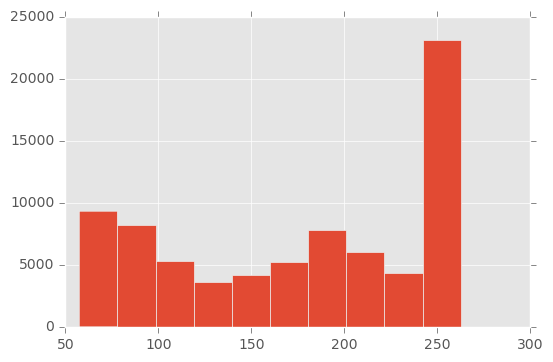

In [18]:
print('Histogram of predicted data')
plt.hist(mlp.predict(X_train_s))
plt.show()

In [19]:
test_error = np.mean(np.abs(mlp.predict(X_test_s) - Y_test))
test_error_med = np.median(np.abs(mlp.predict(X_test_s) - Y_test))
print('Mean error on test is %f. Median error is %f' % (test_error, test_error_med))

Mean error on test is 115.093992. Median error is 101.522626


## Decision trees

Let's try using decision trees.

In [20]:
from sklearn import tree
clf = tree.DecisionTreeRegressor(min_samples_leaf=50)
clf = clf.fit(X_train_s, Y_train)

In [21]:
print_errors(clf, X_train_s, X_test_s, Y_train, Y_test)

[Train] Mean error on is 99.514279 and rmse is 119.474830
[Test] Mean error on is 106.144633 and rmse is 127.818710


In [22]:
print_predictions(clf, X_train_s, X_test_s)

[Train] Mean prediction for model 181.988993
[Train] Std prediction for model 84.075684
[Test] Mean prediction for model 181.224581
[Test] Std prediction for model 85.114376


Note that the good way to proceed would be to perform a random search over the parameters to explore and select the best configuration on the validation set (TODO)